In [1]:
import torch
print("CUDA disponible:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Dispositivo GPU:", torch.cuda.get_device_name(0))
else:
    print("Ejecutando en CPU")

CUDA disponible: True
Dispositivo GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [3]:
mkdir -p /home/mariano/ia_env/dataset_espectros

In [ ]:
## Generar los espectrogramas y guardarlos como imagenes

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

def generar_espectrograma_png(ruta_audio, salida_imagen):
    y, sr = librosa.load(ruta_audio, sr=22050, duration=3.0)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(S_DB, sr=sr, cmap='magma')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(salida_imagen, bbox_inches='tight', pad_inches=0)
    plt.close()

# Configurar rutas base
entrada_base = '/home/mariano/ia_env/data/audio/IRMAS-TrainingData'
salida_base = '/home/mariano/ia_env/dataset_espectros'
instrumentos = ['tru', 'sax', 'voi', 'pia', 'cla', 'cel','flu','gac','gel','org','vio']  # agregá los que quieras usar

for inst in instrumentos:
    archivos = glob.glob(os.path.join(entrada_base, inst, '*.wav'))
    salida_clase = os.path.join(salida_base, inst)
    os.makedirs(salida_clase, exist_ok=True)

    for i, wav_path in enumerate(archivos):
        nombre = f"{inst}_{i}.png"
        ruta_salida = os.path.join(salida_clase, nombre)
        generar_espectrograma_png(wav_path, ruta_salida)

In [ ]:
## Generar codigo base para cargar los datos

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms

print("✅ CUDA disponible:", torch.cuda.is_available())
print("📦 Torch version:", torch.__version__)
print("📦 TorchVision version:", torchvision.__version__)

✅ CUDA disponible: True
📦 Torch version: 2.5.1+cu121
📦 TorchVision version: 0.20.1+cu121


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformaciones para normalizar y convertir a tensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset completo
dataset = datasets.ImageFolder(root='/home/mariano/ia_env/dataset_espectros', transform=transform)

# División en train y test
from torch.utils.data import random_split

longitudes = [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
train_dataset, test_dataset = random_split(dataset, longitudes)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
## Mostrar 5 espectogramas cargados juntos con etiquetas

Forma del batch: torch.Size([32, 3, 128, 128])
Etiquetas del batch: tensor([ 0,  9,  9,  9, 10])


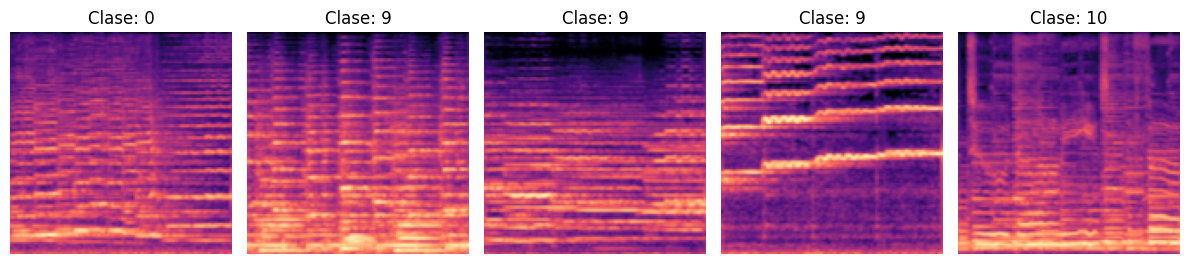

In [7]:
import matplotlib.pyplot as plt

# Obtener una batch
images, labels = next(iter(train_loader))

print(f"Forma del batch: {images.shape}")
print(f"Etiquetas del batch: {labels[:5]}")  # Primeras 5 etiquetas

# Mostrar algunas imágenes
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axs[i].imshow(images[i].permute(1, 2, 0))  # Convertir de CHW a HWC
    axs[i].set_title(f"Clase: {labels[i].item()}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [8]:
print("Clases:", dataset.classes)

Clases: ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']


In [ ]:
## definir la CNN

In [9]:
import torch.nn as nn

class InstrumentCNN(nn.Module):
    def __init__(self, num_classes):
        super(InstrumentCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Entrada RGB
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),  # Si usás Resize (128,128)
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)  # Para clasificación multiclase
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
##Preparar modelo y entrenamiento

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = InstrumentCNN(num_classes=len(dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
## Loop de entrenamiento (10 epocas)

In [13]:
for epoch in range(10):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Época {epoch+1}, Pérdida: {running_loss:.3f}")

Época 1, Pérdida: 311.724
Época 2, Pérdida: 311.556
Época 3, Pérdida: 309.738
Época 4, Pérdida: 309.491
Época 5, Pérdida: 308.185
Época 6, Pérdida: 307.414
Época 7, Pérdida: 306.226
Época 8, Pérdida: 306.285
Época 9, Pérdida: 308.036
Época 10, Pérdida: 305.054


In [ ]:
## Evaluar el rendimiento en el test set

🔍 Classification Report:

              precision    recall  f1-score   support

         cel       0.00      0.00      0.00        91
         cla       0.45      0.21      0.29       100
         flu       0.47      0.27      0.35       103
         gac       0.50      0.67      0.57       127
         gel       0.51      0.59      0.55       155
         org       0.48      0.74      0.58       129
         pia       0.46      0.53      0.49       134
         sax       0.35      0.45      0.39       125
         tru       0.69      0.42      0.52       129
         vio       0.40      0.49      0.44       102
         voi       0.58      0.68      0.63       146

    accuracy                           0.49      1341
   macro avg       0.45      0.46      0.44      1341
weighted avg       0.46      0.49      0.46      1341



/home/mariano/ia_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mariano/ia_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mariano/ia_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


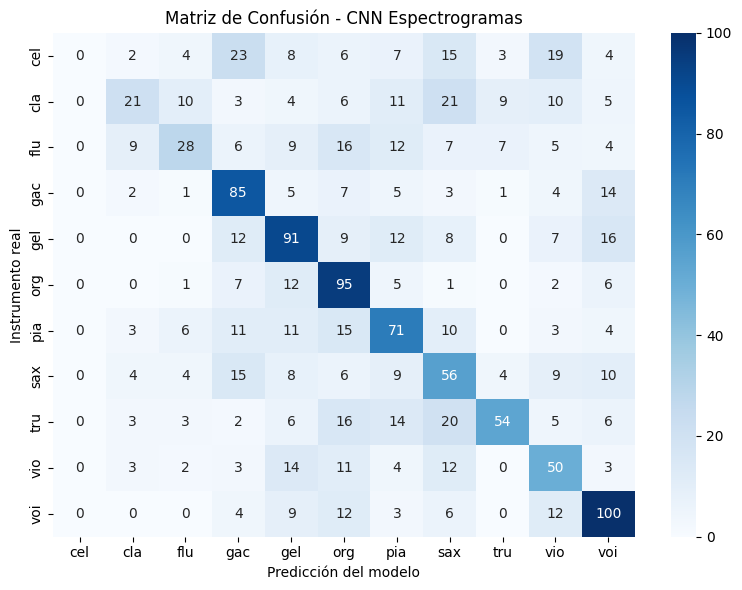

In [14]:
#Este bloque permite calcular el accuracy, 
#generar el classification report, y mostrar la matriz de confusión.

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarse de que el modelo está en modo evaluación
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# 🔍 Reporte de clasificación
print("🔍 Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=dataset.classes))

# 📊 Matriz de Confusión
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Matriz de Confusión - CNN Espectrogramas")
plt.xlabel("Predicción del modelo")
plt.ylabel("Instrumento real")
plt.tight_layout()
plt.show()

In [15]:
import os
os.makedirs('/home/mariano/ia_env/modelos_guardados', exist_ok=True)

In [16]:
torch.save(model.state_dict(), '/home/mariano/ia_env/modelos_guardados/cnn_espectros_v1.pt')

In [ ]:
#para cargar el modelo despues :

In [ ]:
# Crear una nueva instancia
modelo_recargado = InstrumentCNN(num_classes=len(dataset.classes))
modelo_recargado.load_state_dict(torch.load('/home/mariano/ia_env/modelos_guardados/cnn_espectros_v1.pt'))
modelo_recargado.to(device)
modelo_recargado.eval()